In [5]:
import pandas as pd

# Load session-level features
oct_data = pd.read_csv(r"D:\Sparkathon\Data\phase2_Oct_session_features.csv", parse_dates=["session_start", "session_end"])
nov_data = pd.read_csv(r"D:\Sparkathon\Data\phase2_Nov_session_features.csv", parse_dates=["session_start", "session_end"])

# Combine both
data = pd.concat([oct_data, nov_data], ignore_index=True)

#  Save to file
data.to_csv("phase2_OctNov_combined_session_features.csv", index=False)
print("Combined data saved as phase2_OctNov_combined_session_features.csv")


Combined data saved as phase2_OctNov_combined_session_features.csv


In [11]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data
data = pd.read_csv(r"D:\Sparkathon\Data\phase2_OctNov_combined_session_features.csv", parse_dates=['session_start'])

# Step 1: Add daily date column
data['date'] = data['session_start'].dt.date

# Step 2: Aggregate daily purchases per user
daily = data.groupby(['user_id', 'date'])['made_purchase'].sum().reset_index()
daily.columns = ['user_id', 'ds', 'y']

print("Daily user-level demand:", daily.shape)

# Step 3: Focus on top 5 active users (who purchased most)
top_users = daily.groupby('user_id')['y'].sum().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 users:", top_users)

# Step 4: Create forecast folder to save output
forecast_dir = "user_forecasts"
os.makedirs(forecast_dir, exist_ok=True)

# Step 5: Forecast for each top user
for user in top_users:
    print(f"\n📈 Forecasting for user: {user}")
    
    user_df = daily[daily['user_id'] == user].copy()
    user_df['ds'] = pd.to_datetime(user_df['ds'])
    
    # Train-test split
    train = user_df[:-15]
    test = user_df[-15:]
    
    # Prophet model
    model = Prophet(daily_seasonality=True)
    model.fit(train)
    
    # Future df
    future = model.make_future_dataframe(periods=15)
    forecast = model.predict(future)
    
    # Clean forecast
    forecast_clean = forecast[['ds', 'yhat']].copy()
    forecast_clean.rename(columns={'yhat': 'predicted_purchases'}, inplace=True)
    
    # Merge for evaluation
    merged = pd.merge(user_df, forecast_clean, on='ds', how='left')
    eval_df = merged.tail(15)
    
    # 🛠 Drop any rows with NaNs
    eval_df = eval_df.dropna(subset=['y', 'predicted_purchases'])

    # Now evaluate
    mae = mean_absolute_error(eval_df['y'], eval_df['predicted_purchases'])
    rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['predicted_purchases']))
    
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(user_df['ds'], user_df['y'], label='Actual')
    plt.plot(forecast_clean['ds'], forecast_clean['predicted_purchases'], label='Forecast')
    plt.title(f'User {user} - Demand Forecast')
    plt.xlabel('Date')
    plt.ylabel('Purchases')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(forecast_dir, f"user_{user}_forecast.png"))
    plt.close()
    
    # Save forecast
    forecast_clean.to_csv(os.path.join(forecast_dir, f"user_{user}_forecast.csv"), index=False)

print("\nAll forecasts and plots saved in:", forecast_dir)


Daily user-level demand: (15058865, 3)
Top 5 users: [512386086, 549030056, 538340540, 549109608, 538473314]

📈 Forecasting for user: 512386086


19:17:31 - cmdstanpy - INFO - Chain [1] start processing
19:17:31 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.63, RMSE: 5.10


19:17:32 - cmdstanpy - INFO - Chain [1] start processing



📈 Forecasting for user: 549030056


19:17:33 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.27, RMSE: 3.88


19:17:33 - cmdstanpy - INFO - Chain [1] start processing



📈 Forecasting for user: 538340540


19:17:33 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.41, RMSE: 6.56


19:17:34 - cmdstanpy - INFO - Chain [1] start processing



📈 Forecasting for user: 549109608


19:17:34 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.25, RMSE: 3.71


19:17:35 - cmdstanpy - INFO - Chain [1] start processing



📈 Forecasting for user: 538473314


19:17:35 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.28, RMSE: 3.88

All forecasts and plots saved in: user_forecasts


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os

# === STEP 1: Load Cleaned Data (Oct + Nov) ===
data = pd.read_csv(r"D:\Sparkathon\Data\phase2_OctNov_combined_session_features.csv", parse_dates=['session_start'])

# === STEP 2: Create Daily Platform Demand ===
data['date'] = data['session_start'].dt.date
daily_demand = data.groupby('date')['made_purchase'].sum().reset_index()
daily_demand.columns = ['ds', 'y']  # Prophet naming

# ✅ Convert to datetime for Prophet compatibility
daily_demand['ds'] = pd.to_datetime(daily_demand['ds'])

# ✅ Optional Smoothing: Rolling mean + back/forward fill (new syntax)
daily_demand['y'] = daily_demand['y'].rolling(3, center=True).mean().bfill().ffill()

# === STEP 3: Train-Test Split ===
train = daily_demand[:-15]
test = daily_demand[-15:]

# === STEP 4: Train Prophet Model ===
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=False,
    weekly_seasonality=True,
    changepoint_prior_scale=0.5
)
model.fit(train)

# === STEP 5: Forecast Next 15 Days ===
future = model.make_future_dataframe(periods=15)
forecast = model.predict(future)

# === STEP 5b: Clean and Save Forecast ===
forecast_clean = forecast[['ds', 'yhat']].copy()
forecast_clean.rename(columns={'ds': 'date', 'yhat': 'predicted_daily_purchases'}, inplace=True)

# ✅ Convert date for merge
forecast_clean['date'] = pd.to_datetime(forecast_clean['date'])

# 📅 Select only next 15 days (December forecast)
future_forecast = forecast_clean.tail(15).reset_index(drop=True)
future_forecast['cumulative_predicted'] = future_forecast['predicted_daily_purchases'].cumsum()

# ✅ Save Forecast
forecast_path = r"D:\Sparkathon\Data\phase3b_total_demand_forecast.csv"
future_forecast.to_csv(forecast_path, index=False)

# === STEP 6: Evaluation ===
# ✅ Ensure datetime type before merging
merged = pd.merge(daily_demand, forecast_clean, left_on='ds', right_on='date')
eval_df = merged.tail(15)

mae = mean_absolute_error(eval_df['y'], eval_df['predicted_daily_purchases'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['predicted_daily_purchases']))

print(f"✅ Final Evaluation:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

# === STEP 8: Save Model ===
joblib.dump(model, r"D:\Sparkathon\Data\phase3b_prophet_model.pkl")


18:05:39 - cmdstanpy - INFO - Chain [1] start processing
18:05:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Final Evaluation:
MAE: 14470.99
RMSE: 29962.52


['D:\\Sparkathon\\Data\\phase3b_prophet_model.pkl']

In [83]:
from prophet import Prophet
import pandas as pd

# ✅ Your daily_demand dataset (with 'ds' and 'y')
# Make sure 'ds' is in datetime format
daily_demand['ds'] = pd.to_datetime(daily_demand['ds'])

# ✅ Train on Oct + Nov
train = daily_demand  # assuming you've already selected Oct+Nov only

# ✅ Fit the model
model = Prophet(daily_seasonality=True)
model.fit(train)

# ✅ Check last date in training
last_train_date = train['ds'].max()
print("Last train date:", last_train_date)

# ✅ We want to forecast for 15 days **after** last train date
# So calculate how many more days are needed
forecast_horizon = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=15)

# ✅ Create future dataframe to include exactly till Dec 15
future = model.make_future_dataframe(periods=15, freq='D')  # daily frequency

# ✅ Predict
forecast = model.predict(future)

# ✅ Filter forecast to only December predictions (post training period)
future_forecast = forecast[forecast['ds'] > last_train_date][['ds', 'yhat']].copy()
future_forecast.rename(columns={
    'ds': 'date',
    'yhat': 'predicted_purchases'
}, inplace=True)

future_forecast.reset_index(drop=True, inplace=True)

# ✅ Add cumulative forecast (optional)
future_forecast['cumulative_predicted'] = future_forecast['predicted_purchases'].cumsum()

# ✅ Save or display
future_forecast.to_csv("dec_forecast_only.csv", index=False)
print(future_forecast)


17:46:20 - cmdstanpy - INFO - Chain [1] start processing
17:46:20 - cmdstanpy - INFO - Chain [1] done processing


Last train date: 2019-11-30 00:00:00
         date  predicted_purchases  cumulative_predicted
0  2019-12-01         49979.669660          49979.669660
1  2019-12-02         29109.848709          79089.518369
2  2019-12-03         28278.500099         107368.018468
3  2019-12-04         28769.946231         136137.964699
4  2019-12-05         28239.695753         164377.660452
5  2019-12-06         28008.482039         192386.142492
6  2019-12-07         34165.404987         226551.547479
7  2019-12-08         51577.668596         278129.216075
8  2019-12-09         30707.847645         308837.063720
9  2019-12-10         29876.499036         338713.562755
10 2019-12-11         30367.945167         369081.507923
11 2019-12-12         29837.694690         398919.202612
12 2019-12-13         29606.480976         428525.683588
13 2019-12-14         35763.403923         464289.087511
14 2019-12-15         53175.667533         517464.755044


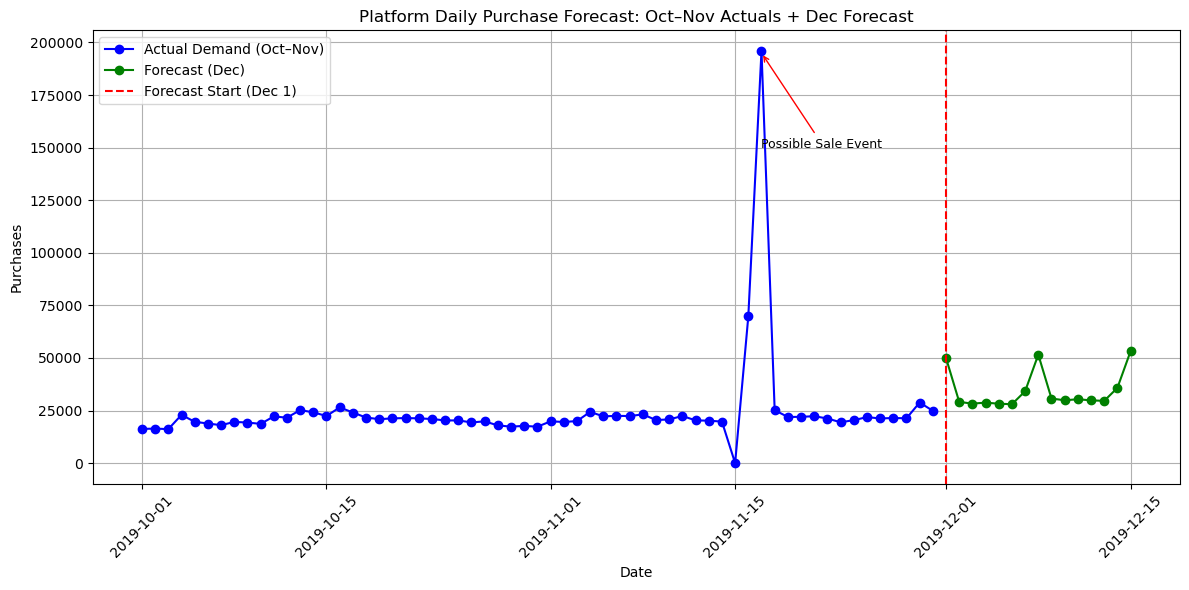

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib

# === Load saved model and forecast ===
model = joblib.load(r"D:\Sparkathon\Notebooks\phase3b_prophet_model.pkl")
forecast_path = r"D:\Sparkathon\Notebooks\dec_forecast_only.csv"
future_forecast = pd.read_csv(forecast_path, parse_dates=['date'])

# === Load full daily demand data (Oct + Nov) ===
data = pd.read_csv(r"D:\Sparkathon\Data\phase2_OctNov_combined_session_features.csv", parse_dates=['session_start'])

# === Aggregate daily purchases ===
data['date'] = data['session_start'].dt.date
daily_demand = data.groupby('date')['made_purchase'].sum().reset_index()
daily_demand.columns = ['date', 'y']
daily_demand['date'] = pd.to_datetime(daily_demand['date'])

# === Plot Full Oct–Nov Actuals + Dec Forecast ===
plt.figure(figsize=(12, 6))

# Plot full Oct–Nov actuals
plt.plot(daily_demand['date'], daily_demand['y'], label='Actual Demand (Oct–Nov)', color='blue', marker='o')

# Plot Dec forecast
plt.plot(future_forecast['date'], future_forecast['predicted_purchases'],
         label='Forecast (Dec)', color='green', marker='o')

# Add red vertical line on Dec 1
dec_1 = future_forecast['date'].iloc[0]
plt.axvline(x=dec_1, color='red', linestyle='--', label='Forecast Start (Dec 1)')

# Annotate spike (convert to Timestamp)
plt.annotate("Possible Sale Event",
             xy=(pd.Timestamp('2019-11-17'), 195000),
             xytext=(pd.Timestamp('2019-11-17'), 150000),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=9)

# Format the plot
plt.title("Platform Daily Purchase Forecast: Oct–Nov Actuals + Dec Forecast")
plt.xlabel("Date")
plt.ylabel("Purchases")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save & show plot
plt.savefig(r"D:\Sparkathon\Data\phase3b_forecast_plot_with_dec_line_full.png")
plt.show()
